In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import warnings
warnings.filterwarnings('ignore')

import data_util as du

sns.color_palette(["#00798c", "#d1495b", '#edae49', '#66a182'])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274)]

In [6]:
file = "data_raw/Flo2.3-A2-33_RmTmp.csv"
df = pd.read_csv(file)
df.head()

,timestamp,index,value[°F]
0,2020-10-09 07:15:00 EDT,96753,64.484375
1,2020-10-09 07:30:00 EDT,96754,64.203125
2,2020-10-09 07:45:00 EDT,96755,64.468750
3,2020-10-09 08:00:00 EDT,96756,64.039062
4,2020-10-09 08:15:00 EDT,96757,63.984375


In [ ]:
df.isnull().sum()

index        0
value[°F]    0
datetime     0
dtype: int64

There doesn't seem to any null values

#### Basic Visualization

In [ ]:
df = du.timestamp_split(file)
df.head()

index                 int64
value[°F]           float64
datetime     datetime64[ns]
dtype: object


,index,value[°F],datetime
0,96753,64.484375,2020-10-09 07:15:00
1,96754,64.203125,2020-10-09 07:30:00
2,96755,64.468750,2020-10-09 07:45:00
3,96756,64.039062,2020-10-09 08:00:00
4,96757,63.984375,2020-10-09 08:15:00


Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

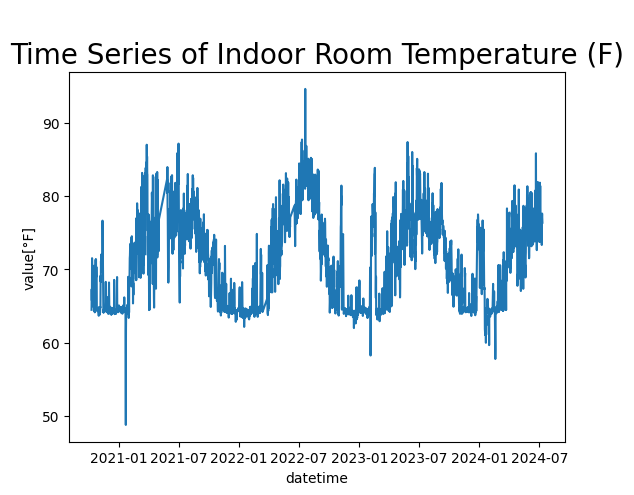

In [10]:
ax = sns.lineplot(data=df[::50], x="datetime", y="value[°F]")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

#### Downsampling
Smooth out data to remove daily fluctuations and see more seasonal changes

Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

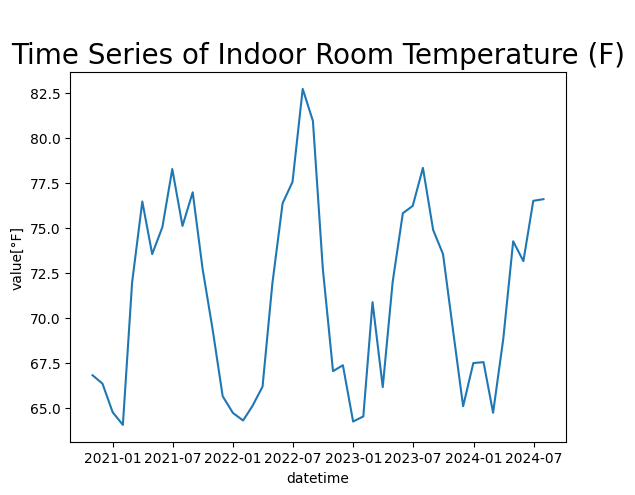

In [17]:
downsample_df = df.resample(rule="M", on="datetime").mean()
ax = sns.lineplot(data=downsample_df, x="datetime", y="value[°F]")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)